In [2]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from discretize_sepsis_actions import discretize_actions

In [214]:
def process_patient_data():
	print ('reading csv ...')
	data = np.genfromtxt('../Dataset/Sepsis_imp.csv', dtype=float, delimiter=',', skip_header=1)
	print ('reading cluster results ...')
	clusters = pkl.load(open('states_list.pkl', 'rb'), encoding='latin1')
	# get action indices by discretizing [median_vaso, input_4_hourly]
	action_sequence, vaso_bins, iv_bins = discretize_actions(data[:,50], data[:,47])

	patient = {}
	print ('building map ...')
	for i, row in enumerate(data):
		icuid = row[1]
		state_action_outcome = [clusters[i], action_sequence[i], row[50], row[47], row[-2]]
		if icuid not in patient:
			# state_id, action, outcome
			patient[icuid] = [state_action_outcome]
		else:
			patient[icuid].append(state_action_outcome)

	return patient, vaso_bins, iv_bins, clusters

def count2prob(transition_count_table):

	transition_matrix = np.zeros(transition_count_table.shape)

	for s in range(transition_count_table.shape[0]):
		for a in range(transition_count_table.shape[1]):
			if np.sum(transition_count_table[s, a]) > 0:
				transition_matrix[s, a] = transition_count_table[s, a] / (np.sum(transition_count_table[s, a]) * 1.)

	return transition_matrix

def build_MDP(patient_data, num_states=2000, num_actions=25):

	transition_count_table = np.zeros((num_states, num_actions, num_states))
	reward_table = np.zeros((num_states, num_actions, num_states))

	for _, patient_icu_stays in patient_data.items():
		
		if len(patient_icu_stays) <= 5:
			continue

		for i, patient_icu_stay in enumerate(patient_icu_stays): # one stay = 4 hrs
			
			state, action, _, _, outcome = patient_icu_stay
			new_state = patient_icu_stays[i + 1][0]
			
			if (i + 1) == len(patient_icu_stays) - 1:
				# last stay, check the outcome
				if patient_icu_stays[i + 1][-1] == 0: 
					# survived
					reward = 15
				else:
					reward = -15
				
				transition_count_table[state, action, new_state] += 1
				reward_table[state, action, new_state] += reward
				break
			
			transition_count_table[state, action, new_state] += 1

	return count2prob(transition_count_table), reward_table

def solve_MDP( MDP, gamma=0.95, theta=0.001):
	# solve by value iteration
	(transition_matrix, reward_table) = MDP
	# print MDP
	V = np.zeros((transition_matrix.shape[0]))
	# compute V table
	while 1:
		delta = 0.
		for s in range(transition_matrix.shape[0]):
			max_val = np.max(np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1))
			delta = max(delta, abs(max_val - V[s]))
			V[s] = max_val
		if delta < theta:
			break
	# build Q_table
	Q_table = np.zeros((transition_matrix.shape[0], transition_matrix.shape[1]))
	for s in range(transition_matrix.shape[0]):
		Q_table[s] = np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1)

	return V, Q_table 

def policy_eval(MDP, prob_e, gamma=.95):
	# solve by value iteration
	(transition_matrix, reward_table) = MDP
    # print MDP
	V = np.zeros((transition_matrix.shape[0]))
    # compute V table
	while 1:
		
		delta = 0.
		
		for s in range(transition_matrix.shape[0]):
			v = np.sum(prob_e[s] * np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1))
			delta = max(delta, abs(v - V[s]))
			V[s] = v

		if delta < 0.001:
			break
            
	# build Q_table
	Q = np.zeros((transition_matrix.shape[0], transition_matrix.shape[1]))
	for s in range(transition_matrix.shape[0]):
		Q[s] = np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1)
	return V, Q

def offline_sample_qlearning(patient, num_states, num_actions, alpha=0.3, gamma=0.95):
	
	size = len(patient)

	Q = np.zeros((num_states, num_actions))

	iter_count = 0
	delta = 0.

	Q_sum = np.zeros(5 * 10**6)
	
	while 1:
		
		if iter_count % 10000 == 0:
			print ('iter: ', iter_count)

		# sample
		icuid = patient.keys()[np.random.choice(size)]
		patient_icu_stays = patient[icuid]

		if len(patient_icu_stays) <= 5:
			continue
		# learn
		for i, patient_icu_stay in enumerate(patient_icu_stays):
			
			s, a, _, _, _ = patient_icu_stay
			new_s = patient_icu_stays[i + 1][0]
			reward = 0

			if (i + 1) == len(patient_icu_stays) - 1:

				# last stay, check the outcome
				if patient_icu_stays[i + 1][-1] == 0: 
					# survived
					reward = 15
				else:
					reward = -15
				
			# Q before update
			prev_Q = np.sum(Q)
			Q[s, a] = Q[s, a] + alpha * (reward + gamma * np.max(Q[new_s]) - Q[s, a])
			delta = max(delta, abs(prev_Q - np.sum(Q)))
			
			if reward != 0:
				break

		Q_sum[iter_count] = np.sum(Q)
		iter_count += 1
		
		if iter_count == 5 * 10**6:
			break

		if iter_count > 1 * 10**6 and delta < 10:
			break
	return Q

def q2prob_e(Q):
	prob_e = np.zeros(Q.shape)
	for s in range(Q.shape[0]):
		prob_e[s, np.argmax(Q[s])] = 1
	return prob_e

def get_bins(devs, outcomes, bin_width):

	bins = np.linspace(np.min(devs), np.max(devs), 10)
	bins = np.sort(np.insert(bins, 0, 0.0))

	bin_vals = {}
	for i in range(bins.shape[0]):
		bin_vals[i] = []
        
	for i, dev in enumerate(devs):
		bin_idx = 0
		for bin_element in bins:
			if dev < bin_element:
				bin_vals[bin_idx] += [outcomes[i]]
				break
			else:
				bin_idx += 1

	bin_vals_list = []
	bin_edges = []

	for key, val in bin_vals.items():
		if len(val) != 0:
			bin_edges += [bins[key]]
			bin_vals_list += [np.mean(val)]

	return bin_vals_list, bin_edges

def plot_data_deviation_mortality(patient, Q_table, bins):
	vaso_bins, iv_bins = bins
	vaso_devs, iv_devs, outcomes = [], [], []

	for _, patient_icu_stays in patient.items():
		if len(patient_icu_stays) <= 5:
			continue

		vaso_dev = 0
		iv_dev = 0

		for i, patient_icu_stay in enumerate(patient_icu_stays):
            
			state, action, iv, vaso, outcome = patient_icu_stay
            
			optimal_action = np.argmax( Q_table[ state , : ] ) 
			optimal_vaso = vaso_bins[optimal_action % 5]
			optimal_iv = iv_bins[int(optimal_action / 5.)]
            
			vaso_dev += ( vaso - optimal_vaso )
			iv_dev += ( iv - optimal_iv )

		vaso_devs += [vaso_dev / len(patient_icu_stays)]
		iv_devs += [iv_dev / len(patient_icu_stays)]
		outcomes += [outcome]

	vaso_bin_vals_list, vaso_bins_val = get_bins(vaso_devs, outcomes, 0.2)
	iv_bin_vals_list, iv_bins_val = get_bins(iv_devs, outcomes, 400)
	return vaso_bins_val, iv_bins_val, vaso_bin_vals_list, iv_bin_vals_list

reading csv ...
reading cluster results ...
building map ...
building MDP ...


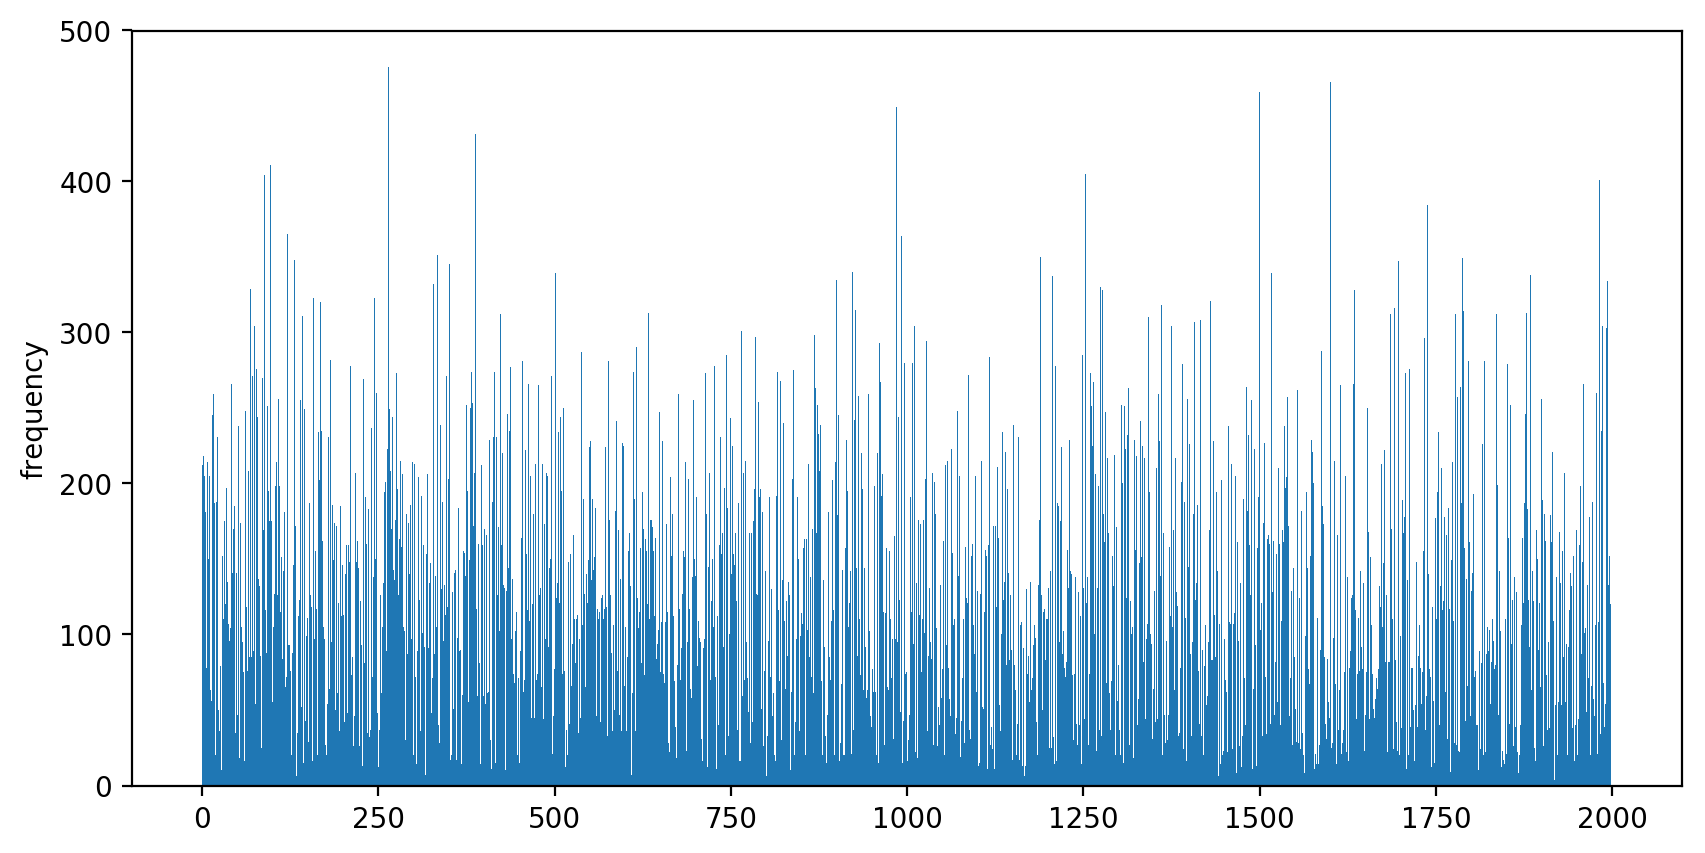

In [215]:
num_states, num_actions = 2000, 25
patient, vaso_bins, iv_bins, clusters = process_patient_data()
print ('building MDP ...')
trainsition_matrix, reward_table = build_MDP(patient)
MDP = (trainsition_matrix, reward_table )

plt.figure(figsize=(10,5), dpi = 200)
plt.hist(clusters, bins=2000)
plt.ylabel('frequency');
plt.show()

In [74]:
print ('solving MDP ...')
v_optimal, q_optimal = solve_MDP( MDP )
print ('done solving MDP')

solving MDP ...


In [50]:
print ('loading clinician policy ...')
clinician_policy = pkl.load(open('clinician_policy.pkl', 'rb'), encoding='latin1')
print ('done loading')

loading clinician policy ...


In [69]:
print ('eval clinician policy ...')
q_clinician = clinician_policy
v_clinician, _ = policy_eval(MDP, q2prob_e(q_clinician))
print ('done eval clinician policy')

eval clinician policy ...
done eval clinician policy


In [52]:
# random action policy
random_action_policy = np.full((num_states, num_actions), 1. / num_actions)
print ('eval random policy ...')
v_random, q_random = policy_eval(MDP, random_action_policy)
print ('done eval random policy')

eval random policy ...
done eval random policy


In [65]:
# no action policy
no_action_prob_e = np.zeros((num_states, num_actions))
no_action_prob_e[:,0] = [1 for _ in range(num_states)]
print ('eval no_action policy ...')
v_no_action, q_no_action = policy_eval(MDP, no_action_prob_e)
print ('done eval random no_action policy')

eval no_action policy ...
done eval random no_action policy


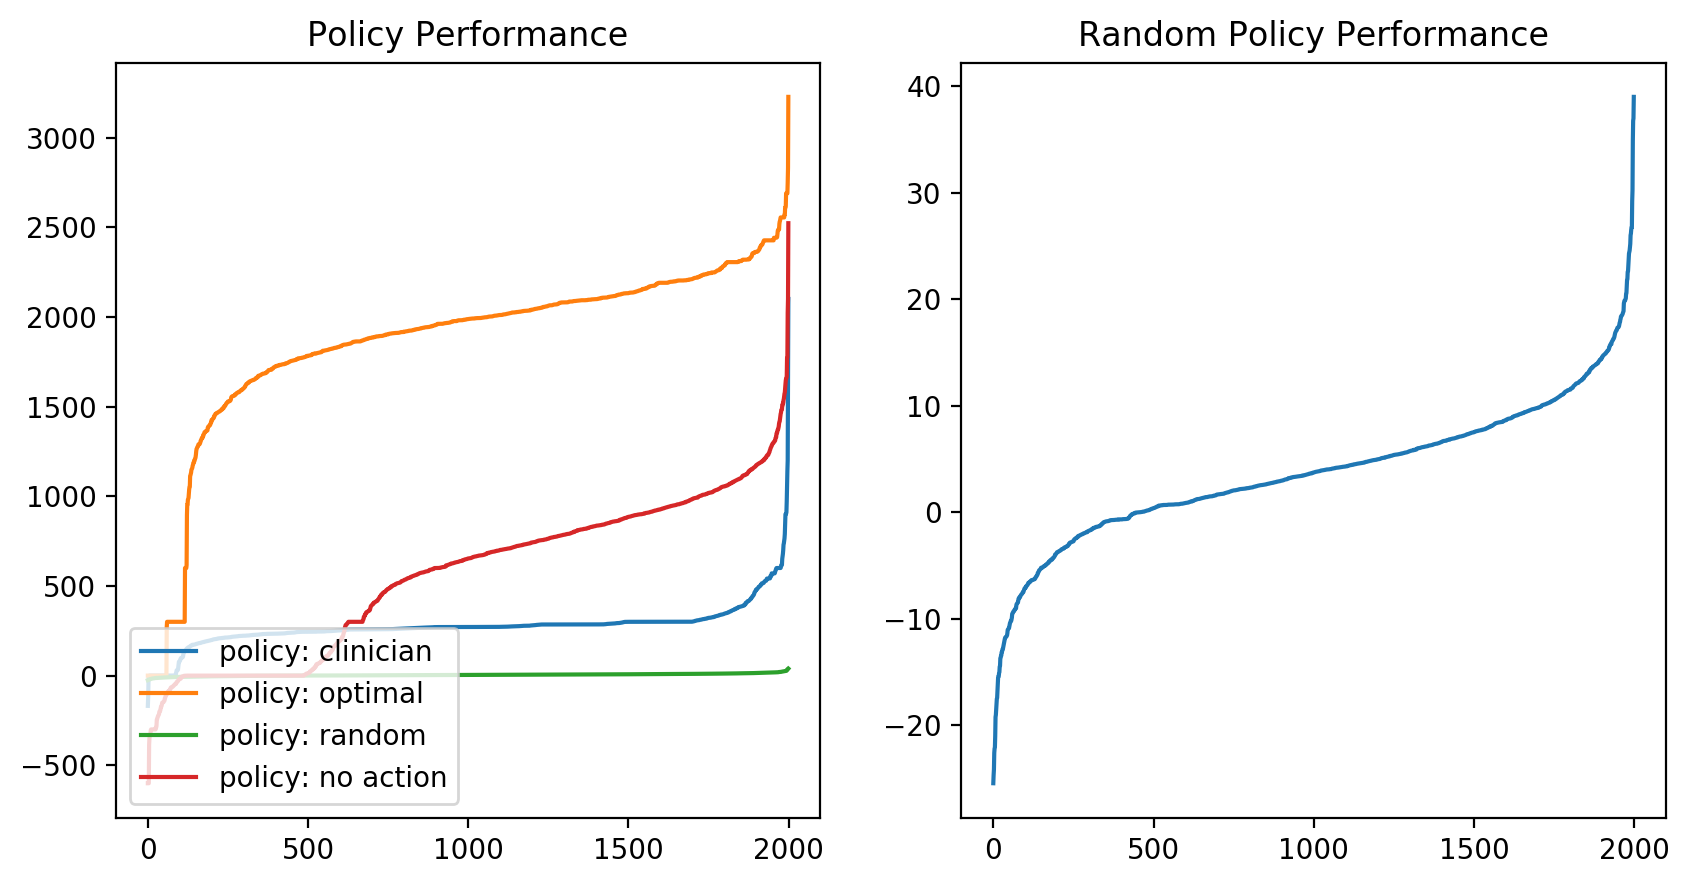

In [76]:
# reward = +/- 100, 0
plt.figure(figsize=(10,5), dpi = 200)
plt.subplot(1,2,1)
plt.title('Policy Performance')
x = np.arange(0, 2000)
ys = [v_clinician, v_optimal, v_random, v_no_action ]
ynames = ['clinician', 'optimal', 'random', 'no action']

for i, y in enumerate(ys):
    plt.plot(x, np.sort(y), label='policy: ' + ynames[i])

plt.legend(loc='lower left', fancybox=True, prop={'size': 10})

plt.subplot(1,2,2)
plt.title('Random Policy Performance')
plt.plot(x, np.sort(ys[2]))

plt.show()

In [195]:
bins = (vaso_bins, iv_bins)
optimal_vaso_bin, optimal_iv_bin, optimal_vaso_val, optimal_iv_val = \
    plot_data_deviation_mortality(patient, q_optimal, bins)

In [196]:
clinician_vaso_bin, clinician_iv_bin, clinician_vaso_val, clinician_iv_val = \
    plot_data_deviation_mortality(patient, q_clinician, bins)

In [197]:
random_vaso_bin, random_iv_bin, random_vaso_val, random_iv_val = \
    plot_data_deviation_mortality(patient, q_random, bins)

In [198]:
no_action_vaso_bin, no_action_iv_bin, no_action_vaso_val, no_action_iv_val = \
    plot_data_deviation_mortality(patient, q_no_action, bins)

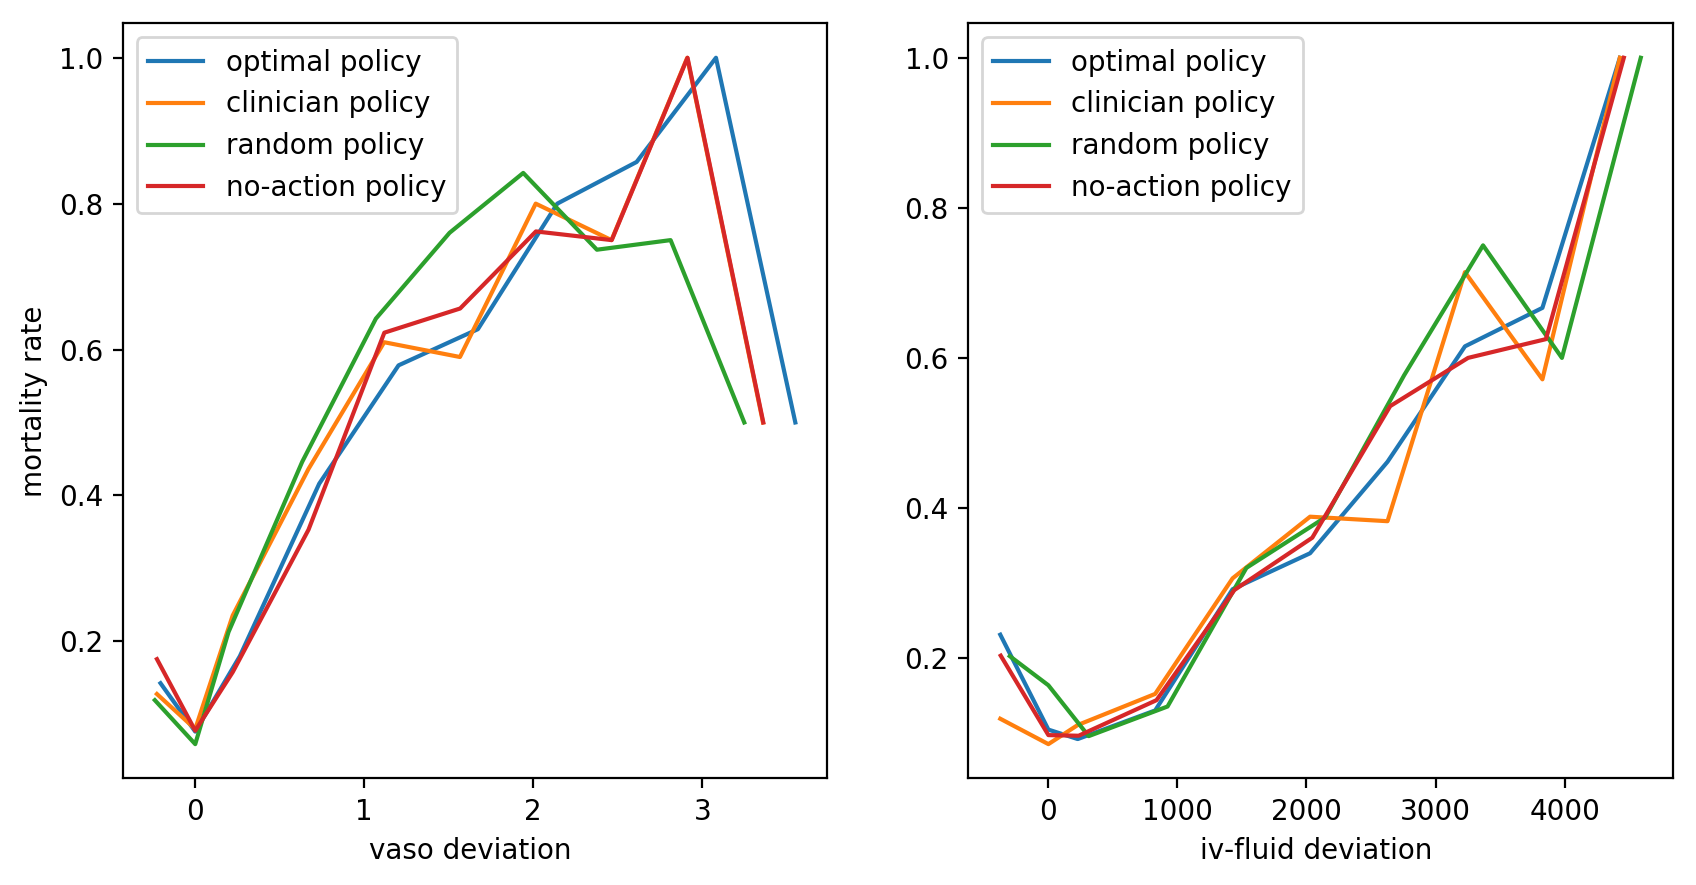

In [213]:
plt.figure(figsize=(10,5), dpi = 200)

plt.subplot(1,2,1)
plt.xlabel('vaso deviation ')
plt.ylabel('mortality rate')
plt.plot(optimal_vaso_bin, optimal_vaso_val,label='optimal policy')
plt.plot(clinician_vaso_bin, clinician_vaso_val,label='clinician policy')
plt.plot(random_vaso_bin, random_vaso_val,label='random policy')
plt.plot(no_action_vaso_bin, no_action_vaso_val,label='no-action policy')

plt.legend(loc='upper left', fancybox=True, prop={'size': 10})

plt.subplot(1,2,2)
plt.xlabel('iv-fluid deviation ')
plt.plot(optimal_iv_bin, optimal_iv_val,label='optimal policy')
plt.plot(clinician_iv_bin, clinician_iv_val,label='clinician policy')
plt.plot(random_iv_bin, random_iv_val,label='random policy')
plt.plot(no_action_iv_bin, no_action_iv_val,label='no-action policy')

plt.legend(loc='upper left', fancybox=True, prop={'size': 10})
plt.show()